# Analysis of transitions between differentiation endpoints

***

Jan T. Schleicher, 2023

Since validation experiments showed that early cells with marker expression corresponding to the memory-like branch could also differentiated into terminally exhausted T cells, we perform Markov chain sampling without fixed endpoints and analyze the proportion of sampled cell sequences with a transition from the memory-like to the terminally exhausted endpoint, and vice versa.

In [1]:
# Import required packages
import os

import numpy as np
np.random.seed(42)
import pandas as pd

import scvelo as scv
import scanpy as sc

import cytopath
from scipy import sparse
from scipy import stats
from scipy.spatial.distance import cosine

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib

%config Completer.use_jedi = False

In [2]:
DATA_PATH = "../data/"
OUTPUT_PATH = "../output/"
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [3]:
adata = sc.read_h5ad(os.path.join(DATA_PATH, "tex_data_chronic_annotated.h5ad"))
adata

AnnData object with n_obs × n_vars = 13410 × 7170
    obs: 'sampleID', 'barcode', 'sample_type', 'timepoint', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mitochondrial', 'log1p_total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'log1p_total_counts_ribosomal', 'pct_counts_ribosomal', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_genes', 'n_counts', 'phase', 'S_score', 'G2M_score', 'score_diff', 'leiden', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'velocity_length', 'velocity_confidence', 'velocity_confidence_transition', 'annot'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mitochondrial', 'ribosomal', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'cell_cycle_genes', 'gene_count_corr', 'means', 'dispersions',

In [4]:
# Create dummy cluster as endpoint for undirected simulations
adata.obs["dummy"] = "1"
adata.obs.dummy = adata.obs.dummy.astype("category")

In [5]:
# Run cytopath without fixed endpoint
if sparse.issparse(adata.X):
    adata.X = adata.X.toarray()

cytopath.sampling(adata, cluster_key='dummy',
                  max_steps=1000,
                  traj_number=10000,
                  sim_number=10000,
                  end_point_probability=0.99,
                  end_clusters=["1"],
                  root_cell_probability=0.99,
                  min_clusters=1, # min. number of clusters a sim must visit
                  auto_adjust=False, # Chooses number of simulations and max_steps
                  num_cores=os.cpu_count())


Sampling round: 0


  0%|          | 0/278 [00:00<?, ?it/s]

Sampling done.


In [6]:
def check_convergence_criteria(eps_history, tol=1e-5):
    differences = [abs(eps_history[i+1]-eps_history[i]) for i in range(len(eps_history)-1)]
    # return first element that is under tolerance threshold
    try:
        return 1 + len(differences) - next(i for i, j in enumerate(differences[::-1]) if j > tol)
    except:
        return None

In [7]:
# Check convergence of cluster proportions to stationary state
tol = 1e-4
cluster = "annot"

stationary_state_probability = pd.DataFrame((adata.obs.end_points / adata.obs.end_points.sum())
                                            .rename("probability"))
stationary_state_probability["cluster"] = adata.obs[cluster].astype("category")
stationary_state_probability_by_cluster = stationary_state_probability.groupby("cluster").sum()

cluster_sequences = adata.obs[cluster].astype(str).values[adata.uns["samples"]["cell_sequences"]]
cluster_proportions = pd.DataFrame(data=np.zeros((len(stationary_state_probability_by_cluster), 1000),
                                                 dtype=np.float),
                                   index=stationary_state_probability_by_cluster.index)
for cat in stationary_state_probability_by_cluster.index:
    cluster_proportions.loc[cat, :] = (cluster_sequences == cat).mean(axis=0)
eps_history = cluster_proportions.apply(lambda x: cosine(x.values.flatten(),
                                                         stationary_state_probability_by_cluster.values.flatten())).values
convergence = check_convergence_criteria(eps_history, tol=tol)

In [8]:
# Calculate cluster proportions per step
cluster_prop_per_step = \
    cluster_proportions.transpose().stack().reset_index().rename(columns={"level_0": "step", 0: "prop"})
cluster_prop_per_step

,step,cluster,prop
0,0,early,1.0000
1,0,eff_like,0.0000
2,0,int_exh,0.0000
3,0,mem_like,0.0000
4,0,prolif,0.0000
...,...,...,...
5995,999,eff_like,0.0292
5996,999,int_exh,0.0001
5997,999,mem_like,0.0797
5998,999,prolif,0.0000


In [9]:
annot_colors = dict(zip(["early", "eff_like", "int_exh", "mem_like", "prolif", "term_exh"],
                        adata.uns["annot_colors"]))
leiden_colors = dict(zip(adata.obs.leiden.cat.categories, adata.uns["leiden_colors"]))

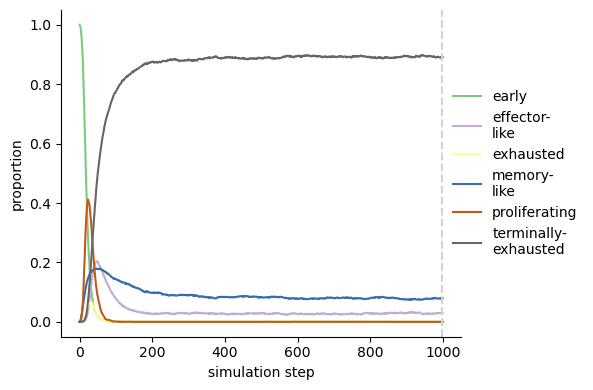

In [10]:
# Plot cluster proportions per step
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(x="step", y="prop", hue="cluster",
             data=cluster_prop_per_step,
             palette=annot_colors, ax=ax)
ax.set_xlabel("simulation step")
ax.set_ylabel("proportion")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=["early", "effector-\nlike", "exhausted", "memory-\nlike",
                                   "proliferating", "terminally-\nexhausted"],
          loc="center left", frameon=False, bbox_to_anchor=(.95, .5))
ax.axvline(convergence, color="lightgrey", linestyle="--")
sns.move_legend(ax, "center left", frameon=False, bbox_to_anchor=(.95, .5), title=None)

fig.tight_layout()
sns.despine()

In [11]:
def calc_chain_proportion(cluster_sequences: np.ndarray, through: str, end_point: str, norm_by="end_point"):
    num_chains = (np.any(cluster_sequences[:,:-1] == through, axis=1) & (cluster_sequences[:,-1] == end_point)).sum()
    if norm_by == "end_point":
        total = np.sum(cluster_sequences[:,-1] == end_point)
        prop_chains = num_chains / total
    elif norm_by == "through":
        total = np.sum(np.any(cluster_sequences == through, axis=1))
        prop_chains = num_chains / total
    else:
        raise ValueError("norm_by must be one of [through, end_point]")
    return num_chains, prop_chains, total

def bootstrap(cluster_sequences: np.ndarray, through: str, end_point: str, norm_by="through", n_resamples=100):
    def make_1d_sample(cluster_sequences, through, end_point, norm_by):
        through_x_end_y = np.any(cluster_sequences[:,:-1] == through, axis=1) & (cluster_sequences[:,-1] == end_point)
        through_x = np.any(cluster_sequences == through, axis=1)
        end_y = cluster_sequences[:,-1] == end_point
        if norm_by == "through":
            return through_x_end_y, through_x
        elif norm_by == "end_point":
            return through_x_end_y, end_y
        else:
            raise ValueError("norm_by must be one of [through, end_point]")
    def statistic(x, y):
        return np.sum(x)/np.sum(y)
    res = stats.bootstrap(make_1d_sample(cluster_sequences, through, end_point, norm_by),
                          statistic=statistic, n_resamples=n_resamples,
                          random_state=42, paired=True, vectorized=False)
    return res.confidence_interval, res.standard_error

In [12]:
# Count the simulations that transition between endpoints (with bootstrapping)
res = {"through": [], "end_point": [], "norm_by": [], "num": [],
       "total": [], "prop": [], "ci_low": [], "ci_high": [], "se": []}
end_states = ["mem_like", "term_exh"]

for through in end_states:
    for end_point in end_states:
        for norm_by in ["through", "end_point"]:
            num, prop, total = calc_chain_proportion(cluster_sequences, through=through,
                                                     end_point=end_point, norm_by=norm_by)
            res["through"].append(through)
            res["end_point"].append(end_point)
            res["norm_by"].append(norm_by)
            res["num"].append(num)
            res["total"].append(total)
            res["prop"].append(prop)
            (ci_low, ci_high), se = bootstrap(cluster_sequences, through=through, end_point=end_point,
                                              norm_by=norm_by, n_resamples=1000)
            res["ci_low"].append(ci_low)
            res["ci_high"].append(ci_high)
            res["se"].append(se)

res = pd.DataFrame(res)
res["ci_low_count"] = (res.ci_low * res.total).round()
res["ci_high_count"] = (res.ci_high * res.total).round()
res

,through,end_point,norm_by,num,total,prop,ci_low,ci_high,se,ci_low_count,ci_high_count
0,mem_like,mem_like,through,796,8259,0.096380,0.090319,0.102537,0.003211,746.0,847.0
1,mem_like,mem_like,end_point,796,797,0.998745,0.992398,1.000000,0.001282,791.0,797.0
2,mem_like,term_exh,through,7221,8259,0.874319,0.867277,0.881280,0.003643,7163.0,7278.0
3,mem_like,term_exh,end_point,7221,8910,0.810438,0.802209,0.818532,0.004154,7148.0,7293.0
4,term_exh,mem_like,through,797,10000,0.079700,0.074600,0.085217,0.002701,746.0,852.0
5,term_exh,mem_like,end_point,797,797,1.000000,NaN,NaN,0.000000,NaN,NaN
6,term_exh,term_exh,through,8910,10000,0.891000,0.884368,0.896900,0.003160,8844.0,8969.0
7,term_exh,term_exh,end_point,8910,8910,1.000000,NaN,NaN,0.000000,NaN,NaN


In [13]:
def errplot(x, y, hue, lb, ub, ax=None, **kwargs):
    data = kwargs.pop("data").copy()
    data[lb] = data[y] - data[lb]
    data[ub] = data[ub] - data[y]
    err_low = data.pivot(index=x, columns=hue, values=lb)
    err_high = data.pivot(index=x, columns=hue, values=ub)
    err = []
    for col in err_low:
        err.append([err_low[col].values, err_high[col].values])
    err = np.abs(err)
    p = data.pivot(index=x, columns=hue, values=y)
    if ax is None:
        ax=plt.gca()
    p.plot(kind="bar", yerr=err, ax=ax, **kwargs)

In [14]:
labels = ["memory-\nlike", "terminally-\nexhausted"]

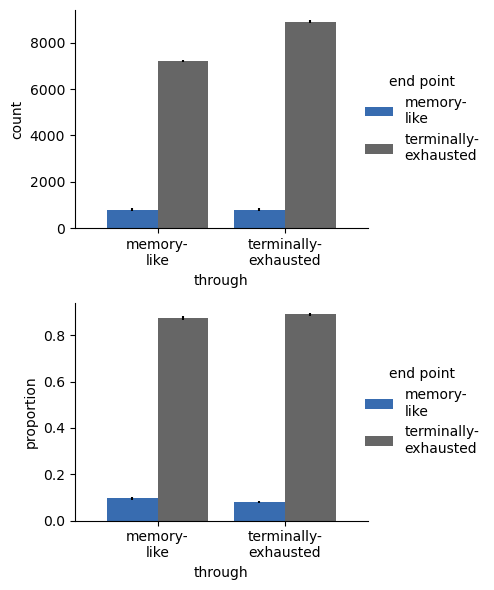

In [16]:
# Plot the proportion of simulations transitioning between endpoints
fig, axs = plt.subplots(2, 1, figsize=(5, 6))

legend_kwargs = {"bbox_to_anchor": (.95, .5), "loc": "center left", "frameon": False,
                 "fontsize": 10, "markerscale": .8, "title_fontsize": 10,
                 "labels": labels}

errplot("through", "num", "end_point", "ci_low_count", "ci_high_count", ax=axs[0],
        data=res[res.norm_by == "through"], width=.8,
        color=[annot_colors["mem_like"], annot_colors["term_exh"]], xlabel="through", ylabel="count")
axs[0].tick_params(rotation=0)
axs[0].set_xticklabels(labels)
axs[0].legend(title="end point", **legend_kwargs)


errplot("through", "prop", "end_point", "ci_low", "ci_high", ax=axs[1],
        data=res[res.norm_by == "through"], width=.8,
        color=[annot_colors["mem_like"], annot_colors["term_exh"]], xlabel="through", ylabel="proportion")
axs[1].tick_params(rotation=0)
axs[1].set_xticklabels(labels)
axs[1].legend(title="end point", **legend_kwargs)

sns.despine()
fig.tight_layout()